In [10]:
import pandas as pd
import numpy as np
import json
from polyglot.text import Text
from polyglot.downloader import downloader
from textblob import TextBlob
import nltk
import timestring
from datetime import datetime
import plotly.plotly as py
import plotly.graph_objs as go
import scipy as sp
import itertools
import simplejson

In [3]:
tweets=pd.read_csv('datasets/pres_tweets.csv')

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2871: DtypeWarning:

Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.



In [8]:
# tweets.body

In [ ]:
import requests

url = "http://api.meaningcloud.com/class-1.1"
headers = {'content-type': 'application/x-www-form-urlencoded'}

iptc = []

for row_id, row in tweets.iterrows():
    if not row_id % 1000:
        print row_id
    payload = "key=9b45d20a6a1e99a054fb10c23e0b1695&txt={}&model=IPTC_en".format(row['body'])
    response = requests.request("POST", url, data=payload, headers=headers)
    iptc.append(simplejson.loads(response.text))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000

In [14]:
tweets['ontology'] = iptc

In [15]:
tweets['ontology']

0        {u'status': {u'msg': u'OK', u'credits': u'1', ...
1        {u'status': {u'msg': u'OK', u'credits': u'1', ...
2        {u'status': {u'msg': u'Request rate limit exce...
3        {u'status': {u'msg': u'OK', u'credits': u'1', ...
4        {u'status': {u'msg': u'OK', u'credits': u'1', ...
5        {u'status': {u'msg': u'Request rate limit exce...
6        {u'status': {u'msg': u'OK', u'credits': u'1', ...
7        {u'status': {u'msg': u'OK', u'credits': u'1', ...
8        {u'status': {u'msg': u'OK', u'credits': u'1', ...
9        {u'status': {u'msg': u'OK', u'credits': u'1', ...
10       {u'status': {u'msg': u'Request rate limit exce...
11       {u'status': {u'msg': u'OK', u'credits': u'1', ...
12       {u'status': {u'msg': u'OK', u'credits': u'1', ...
13       {u'status': {u'msg': u'Request rate limit exce...
14       {u'status': {u'msg': u'OK', u'credits': u'1', ...
15       {u'status': {u'msg': u'OK', u'credits': u'1', ...
16       {u'status': {u'msg': u'Request rate limit exce.

In [16]:
import ast
from collections import Counter

In [33]:
def get_category(ontology):
    cats=[]
    if('category_list' in ontology):
        for category in ontology['category_list']:
            cats.append(category['label'])
    return cats

In [34]:
dat_ont = tweets

In [42]:
tweets.to_pickle('/notebooks/datasets/tweeter_wtih_ontology_.pkl')

In [35]:
dat_ont['categories']=dat_ont['ontology'].map(get_category)
distinct_categories=set([j for i in dat_ont['categories'].values for j in i])
dat_ont = dat_ont[dat_ont.displayName.isin(['Bernie Sanders', 'Donald J. Trump', 'Hillary Clinton'])]
#how many occurances of categories per author
actor_topics=dat_ont.groupby('displayName')['categories'].apply(list)
# actor_topics
actor_topics['Bernie Sanders']=[j for i in actor_topics['Bernie Sanders'] for j in i]
actor_topics['Donald J. Trump']=[j for i in actor_topics['Donald J. Trump'] for j in i]
actor_topics['Hillary Clinton']=[j for i in actor_topics['Hillary Clinton'] for j in i]
# actor_topics
a=actor_topics.map(Counter)
print(len([(k, v) for k, v in a[0].iteritems()]))
print(len([(k, v) for k, v in a[1].iteritems()]))
print(len([(k, v) for k, v in a[2].iteritems()]))

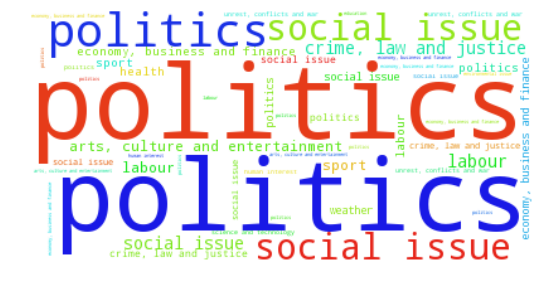

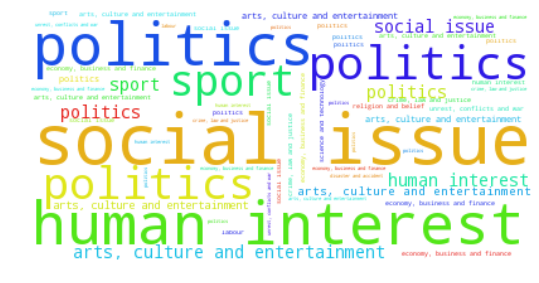

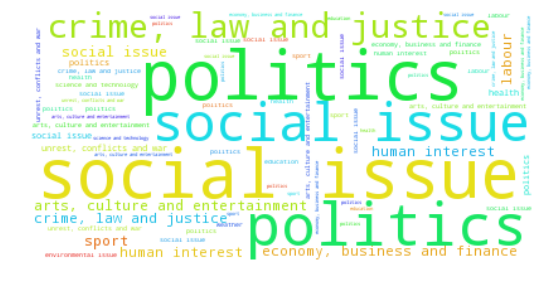

In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

for cand in a:
#     print(cand)
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(
        [(' '.join(k.split(' - ')[2:]), v) for k, v in cand.iteritems()])
    wordcloud = WordCloud(background_color="white").generate_from_frequencies([(' '.join(k.split(' - ')[:1]), v) for k, v in cand.iteritems()])
#     wordcloud = WordCloud(background_color="white").generate_from_frequencies([(' '.join(k.split(' - ')[1:]), v) for k, v in cand.iteritems()])
#     wordcloud = WordCloud(background_color="white").generate_from_frequencies([(' '.join(k.split(' - ')), v) for k, v in cand.iteritems()])
    plt.figure(figsize=(9, 12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [13]:
_[0]

'ICYMI: Sen. Cruz: Obama Administration Demonstrates Contempt for the Law http://t.co/oP6ysKbisU http://t.co/sSu6QhXCBa'

In [12]:
# iptc

In [66]:
def get_entity_sentiment(e):
    try:
        pos=e.positive_sentiment
        neg=e.negative_sentiment
        return pos,neg
    except:
        return '',''
def get_sentiment(t):
    blob = TextBlob(t.decode('utf-8'))
    return map(lambda s:s.sentiment.polarity,blob.sentences)
def get_noun_phrases(t):
    blob = TextBlob(t.decode('utf-8'))
    return list(blob.noun_phrases)
def map_entity(e):
    pos,neg=get_entity_sentiment(e)
    return {'tag':e.tag,'entity':" ".join(e),'pos':pos,'neg':neg}
def get_entites(text):
    try:
        polyglot_text=Text(text)
        entities=polyglot_text.entities
        return map(map_entity,entities)
    except:
        return []
     
def map_to_data(tweet):
    user_name=tweet['user']['name']
    text=tweet['text']
    return {'text':text,'user':user_name,'entities':get_entites(text),'sentiment':get_sentiment(text),'noun_phrases':get_noun_phrases(text)}

In [67]:
tweets['entities']=tweets['body'].map(get_entites)

In [68]:
tweets['sentiment']=tweets['body'].map(get_sentiment)

In [69]:
tweets['noun_phrases']=tweets['body'].map(get_noun_phrases)

In [70]:
tweets['mean_sentiment']=tweets['sentiment'].map(lambda s:reduce(lambda x, y: x + y, s) / len(s))
tweets['postedTime_datetime']=tweets['postedTime'].map(lambda x:pd.to_datetime(str(timestring.Date(x))))
tweets['postedTime_datetime']=pd.DatetimeIndex(tweets['postedTime'])


In [71]:
tweets['displayName']=tweets['displayName'].replace('Senator Ted Cruz','Ted Cruz')
tweets['day']=tweets['postedTime_datetime'].map(lambda x:x.date())
tweets['week']=tweets['day'].map(lambda x:x.isocalendar()[1])

In [72]:
tweets.to_csv('datasets/tweets_with_desc.csv')

In [76]:
candidates=set(tweets['displayName'])

In [128]:
data={}
traces=[]

for candidate in candidates:
    candidateTweets=tweets[tweets['displayName']==candidate]
    sentimentData=candidateTweets[['mean_sentiment','day']]
    data[candidate]=sentimentData
    sentimentData['day']=pd.to_datetime(sentimentData['day'])
    sentimentData.set_index(sentimentData['day'],inplace=True)
    sentimentDataToSave=sentimentData.resample("1d").mean().fillna(0).rolling(window=7, win_type='triang').mean()
    print candidate+': '+str(sentimentDataToSave['mean_sentiment'].std())
    sentimentDataToSave.to_csv('twitter_sentiment/'+candidate+'.csv')
    traces.append(
        go.Scatter(
            x = sentimentDataToSave.index,
            y = sentimentDataToSave['mean_sentiment'],
            mode = 'lines',
            name = candidate
        )
    )
    

Bernie Sanders: 0.0214077000162
Donald J. Trump: 0.0567727607681
John Kasich: 0.0454953165502
Hillary Clinton: 0.0331731459135
Ted Cruz: 0.0330372729758


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [127]:
import plotly.plotly as py
import plotly.graph_objs as go

py.sign_in('RomanBartusiak', 'c10jv3qe0b')
py.iplot(traces, filename='scatter-mode')
   

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:122: InsecurePlatformWarning:

A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.



In [138]:
cols=[]
for k,v in data.iteritems():
    v[k]=v['mean_sentiment']
    cols.append(v[k])

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [142]:
reduce(lambda x,y:pd.concat([x,y],axis=1),cols)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [140]:
for row_id, tweet in tweets.iterrows():
    for ent in tweet['entities']:
        e = ent['entity']
        if e not in entities_count:
            entities_count.update({e: 1})
        else:
            entities_count[e] += 1

In [181]:
entities_count = {k.strip().encode('ascii','ignore'):v for k, v in entities_count.iteritems() if len(k) > 2 and v > 4}

In [182]:
entities_count

{': New Hampshire': 6,
 'ABC': 47,
 'ACA': 6,
 'AMERICA': 32,
 'AMERICA SAFE': 5,
 'Aberdeen': 6,
 'Adam': 16,
 'Affordable': 12,
 'Afghanistan': 10,
 'Aiken': 5,
 'Alabama': 34,
 'Alaska': 10,
 'Alberto Gonzales': 5,
 'America': 757,
 "America's": 7,
 'American': 60,
 'American Airlines Center': 5,
 'Ames': 16,
 'Ames , Iowa': 6,
 'Amir Hekmati': 5,
 'Amnesty': 6,
 'Anderson': 8,
 'Antonin Scalia': 7,
 'Apple': 7,
 'Arizona': 49,
 'Arkansas': 12,
 'Arnold': 5,
 'Assad': 6,
 'Atlanta': 24,
 'Austin': 5,
 'BET': 8,
 'BUSH': 7,
 'Baltimore': 11,
 'Barack Obama': 18,
 'Barbara Walters': 5,
 'Beijing': 8,
 'Ben': 11,
 'Ben Carson': 22,
 'Benghazi': 17,
 'Bern': 31,
 'Bernie': 314,
 'Bernie Sanders': 331,
 "Bernie Sanders's": 7,
 'BernieSanders': 25,
 'Biden': 9,
 'Big Pharma': 9,
 'Bill': 12,
 'Bill Clinton': 8,
 "Bill O'Reilly": 9,
 'Birmingham': 8,
 'Bloomberg': 8,
 'Bluffs , Iowa': 5,
 'Bob': 8,
 'Bob Vander Plaats': 7,
 'Bobby Knight': 7,
 'Boehner': 7,
 'Boston': 17,
 'Boulder': 5,
 '

In [183]:
len(entities_count)

689

In [136]:
for row_id, tweet in tweets.iterrows():
    for ent in tweet['entities']:
        if ent['entity'] not in entities:
            entities[ent['entity']].update({})

In [148]:
!pip2 install wordcloud

/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:315: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#snimissingwarning.
  SNIMissingWarning
/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
  Using cached wordcloud-1.2.1.tar.gz
  Running setup.py bdist_wheel for wordcloud ... - \ done
  Stored in directory: /root/.cache/pip

In [149]:
from wordcloud import WordCloud

In [184]:
wordcloud = WordCloud(background_color="white").generate_from_frequencies(entities_count)

ValueError: could not convert string to float: y

In [ ]:
# def draw_wc_filtered(df, top_n=10, save=False, agg_col=u'Quantity'): 
#     df = pd.DataFrame(df.groupby(u'Group').sum()[agg_col]).sort(
#         agg_col, ascending=False).ix[:top_n].reset_index()
#     df.Group = df.Group.apply(lambda x: x.split(' - ')[1])
#     counts = [((x[1]['Group'].decode('utf-8'), x[1][agg_col])) for x in df.iterrows()]
# #     print counts
#     wordcloud = WordCloud(background_color="white").generate_from_frequencies(counts)
#     plt.figure(figsize=(9, 12))
#     plt.imshow(wordcloud)
#     plt.axis("off")
#     plt.show()
#     if save:
#         plt.savefig('wc/{}.png'.format(save))